In [49]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [51]:
# Load necessary R packages
base = importr('base')
DESeq2 = importr('DESeq2')

In [52]:
Counts = pd.read_csv('HCC364_timecourse.csv', index_col=0)
Counts.head()

DMSO_1  DMSO_2  250D_1  250D_2  30D_1  30D_2  40D_1  40D_2  50D_1  \
Gene                                                                          
A1BG        0.13    0.08    0.43    0.68   0.42   0.54   0.26   0.10   0.24   
A1BG.AS1    0.00    0.00    0.00    0.11   0.23   0.13   0.37   0.14   0.17   
A1CF        0.00    0.01    0.00    0.00   0.02   0.00   0.00   0.01   0.00   
A2M         0.00    0.00    0.00    0.00   0.00   0.00   0.00   0.02   0.00   
A2M.AS1     0.26    0.15    0.17    0.47   0.66   1.03   0.28   0.61   0.59   

          50D_2  
Gene             
A1BG       0.51  
A1BG.AS1   0.29  
A1CF       0.00  
A2M        0.00  
A2M.AS1    0.42

In [53]:
# Convert counts to integers
Counts = Counts.astype(int)

EDA

In [193]:
# Print the sums of each columns
print(Counts.sum(axis=0))

DMSO_1    992966
DMSO_2    992960
250D_1    992873
250D_2    992856
30D_1     992772
30D_2     992781
40D_1     992785
40D_2     992749
50D_1     992755
50D_2     992795
dtype: int64


Library size normalization

In [196]:
# Describe the data
print(Counts.describe())

             DMSO_1        DMSO_2        250D_1        250D_2         30D_1  \
count  26334.000000  26334.000000  26334.000000  26334.000000  26334.000000   
mean      37.706615     37.706387     37.703083     37.702438     37.699248   
std      301.850006    300.777604    369.878693    366.158245    320.512826   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%       15.000000     15.000000     14.000000     14.000000     17.000000   
max    20718.000000  21194.000000  28676.000000  27678.000000  23769.000000   

              30D_2         40D_1         40D_2         50D_1         50D_2  
count  26334.000000  26334.000000  26334.000000  26334.000000  26334.000000  
mean      37.699590     37.699742     37.698375     37.698603     37.700122  
std      315.867766    307.622671    304.977131    358

In [200]:
# Profile report
import pandas_profiling
profile = pandas_profiling.ProfileReport(Counts)

In [ ]:
profile

In [202]:
# info
Counts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26334 entries, A1BG to ZZZ3
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   DMSO_1  26334 non-null  int32
 1   DMSO_2  26334 non-null  int32
 2   250D_1  26334 non-null  int32
 3   250D_2  26334 non-null  int32
 4   30D_1   26334 non-null  int32
 5   30D_2   26334 non-null  int32
 6   40D_1   26334 non-null  int32
 7   40D_2   26334 non-null  int32
 8   50D_1   26334 non-null  int32
 9   50D_2   26334 non-null  int32
dtypes: int32(10)
memory usage: 2.2+ MB


In [203]:
# Duplicated
Counts.duplicated().sum()

13672

In [209]:
# Missing value
Counts.isnull().sum()

DMSO_1    0
DMSO_2    0
250D_1    0
250D_2    0
30D_1     0
30D_2     0
40D_1     0
40D_2     0
50D_1     0
50D_2     0
dtype: int64

In [205]:
# resetting indec
Counts_2 = Counts.reset_index()
Counts_2.head()

Gene  DMSO_1  DMSO_2  250D_1  250D_2  30D_1  30D_2  40D_1  40D_2  \
0      A1BG       0       0       0       0      0      0      0      0   
1  A1BG.AS1       0       0       0       0      0      0      0      0   
2      A1CF       0       0       0       0      0      0      0      0   
3       A2M       0       0       0       0      0      0      0      0   
4   A2M.AS1       0       0       0       0      0      1      0      0   

   50D_1  50D_2  
0      0      0  
1      0      0  
2      0      0  
3      0      0  
4      0      0

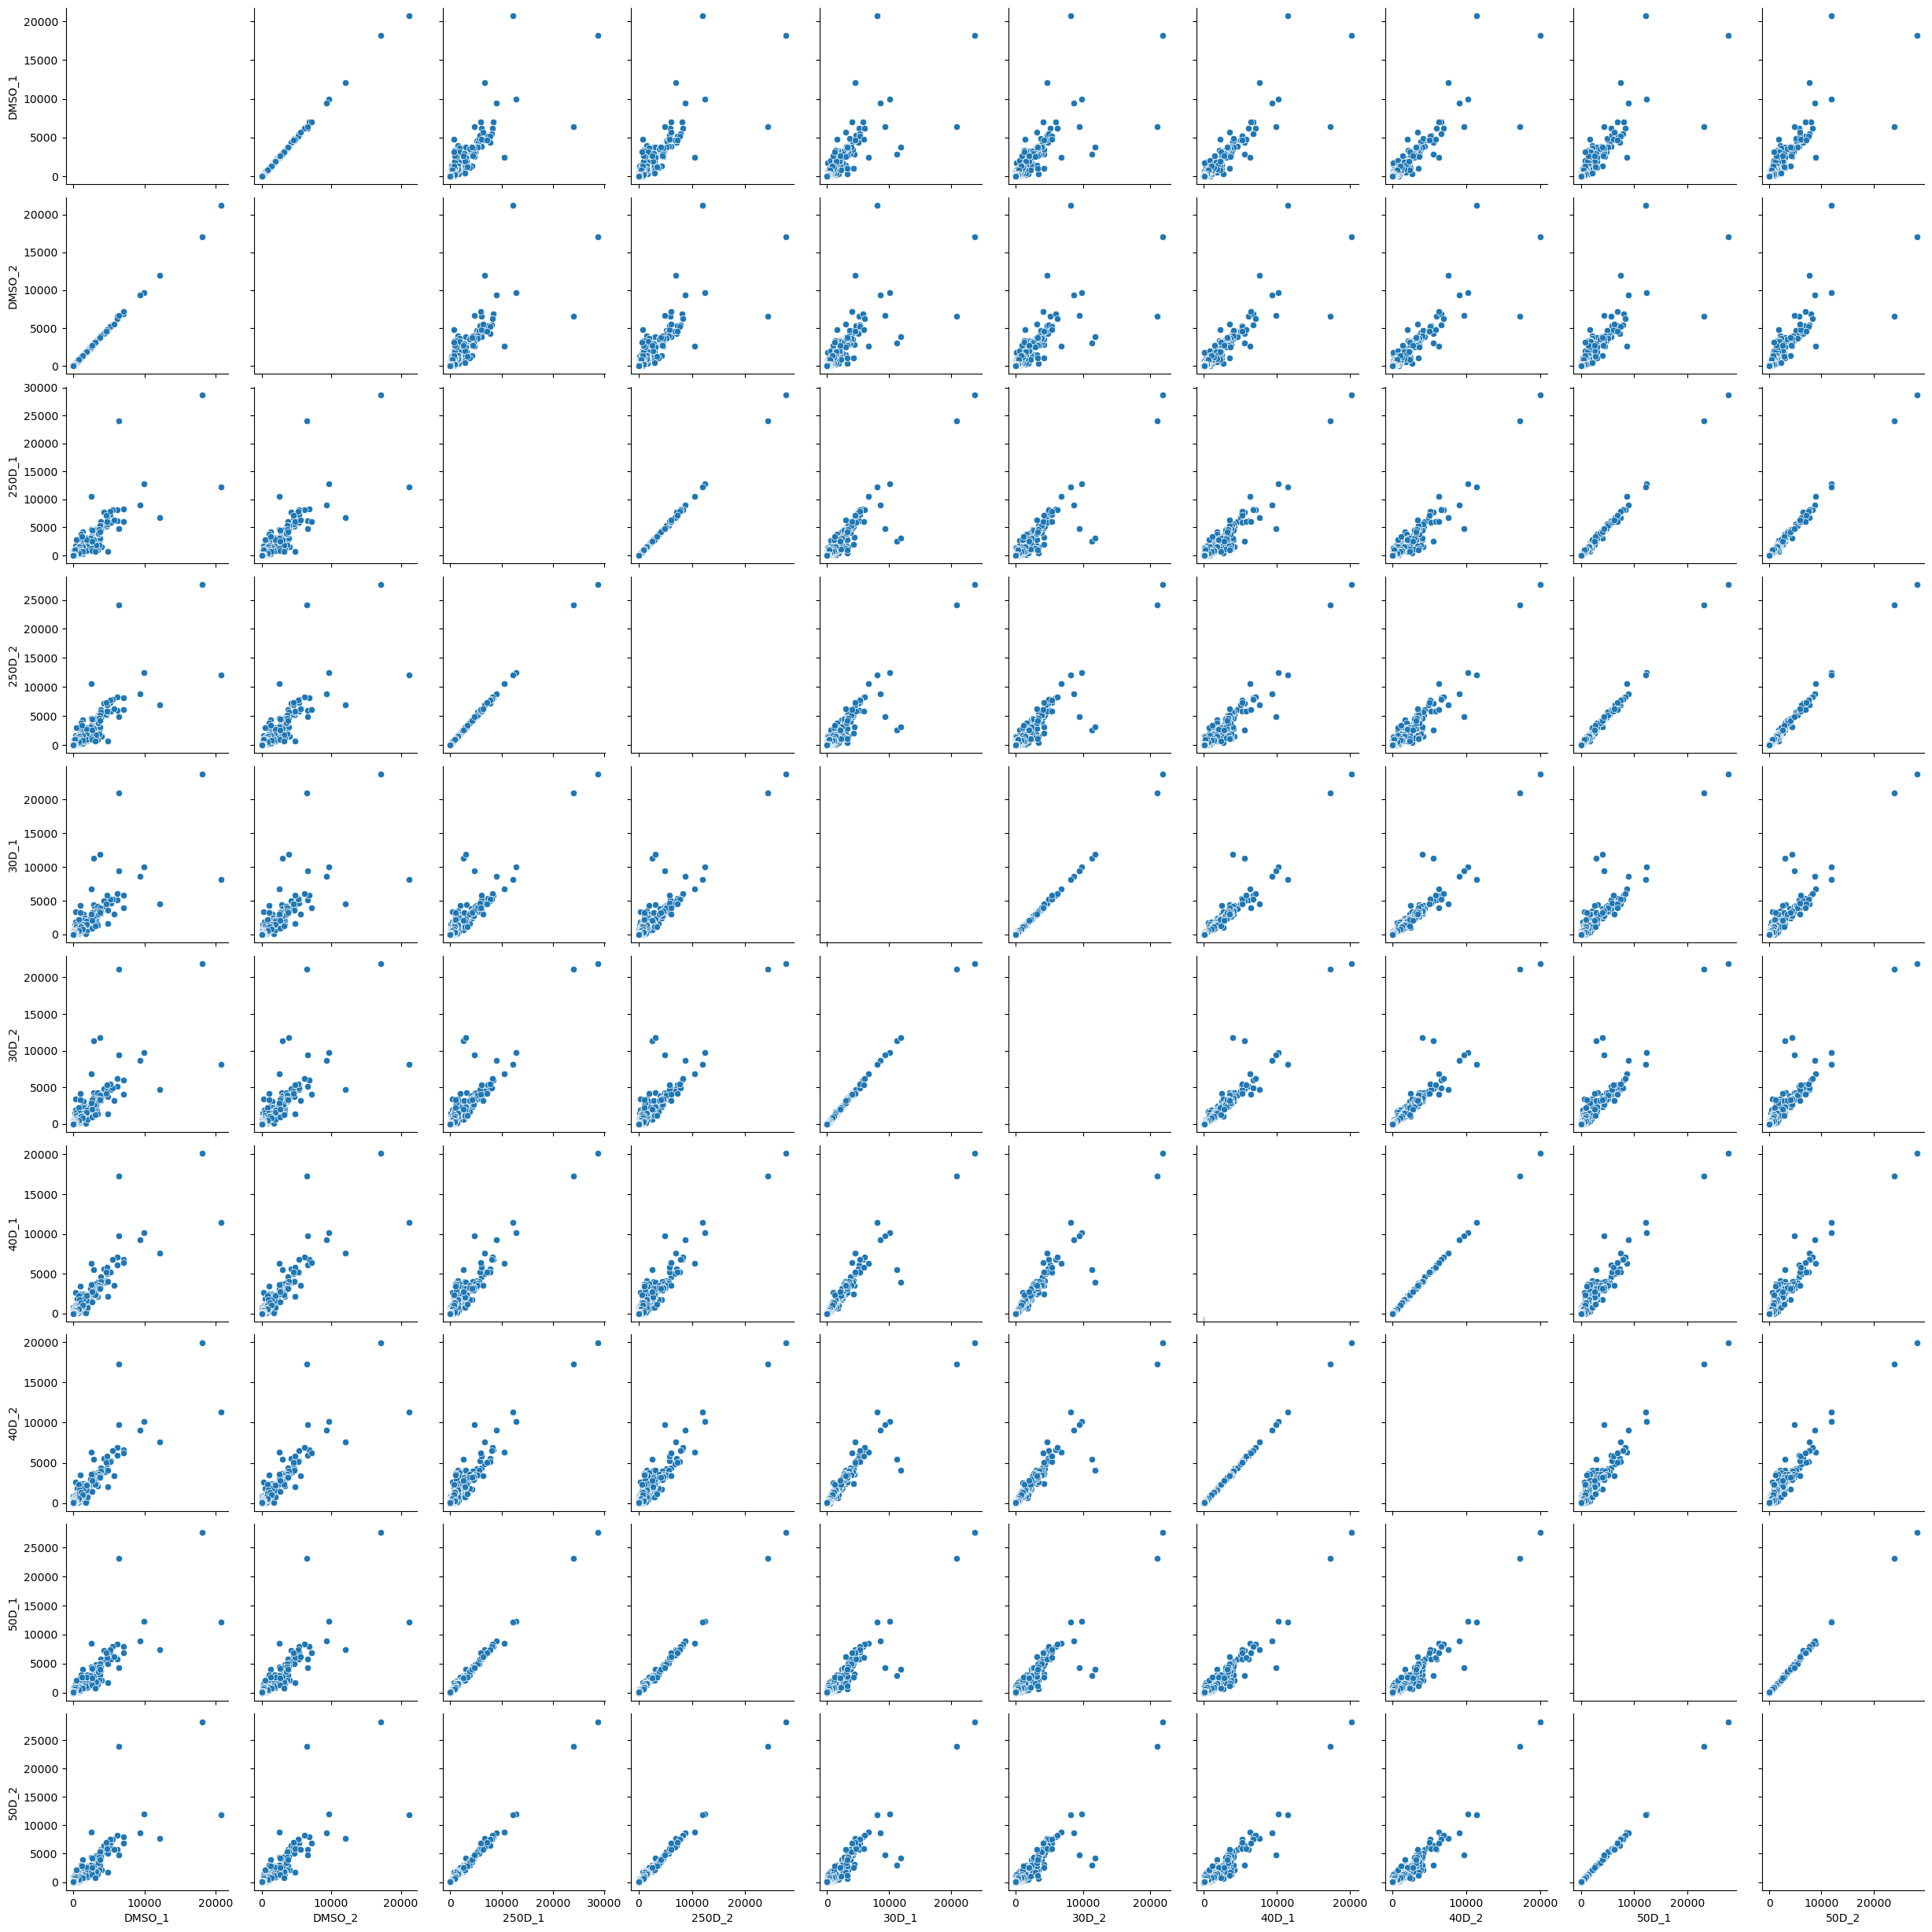

In [208]:
# Create a count plot
sns.pairplot(Counts_2)

In [ ]:
# Generating heatmap
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(Counts, vmin=0, vmax=500)

# Add labels and title if desired
plt.ylabel('Genes')
plt.xlabel('Samples')
plt.title('Gene Expression Heatmap')
plt.show()

In [ ]:
sns.clustermap(Counts, cmap='viridis', figsize=(10, 10))
plt.show()

Analyses

In [54]:
#coldata
# Define the condition factor
condition = ['C', 'C', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S']

# Define colData as a pandas DataFrame
colData = pd.DataFrame({'condition': condition}, index=Counts.columns)

In [55]:
# Convert pandas DataFrames to R data frames
with localconverter(robjects.default_converter + pandas2ri.converter):
    Counts_r = robjects.conversion.py2rpy(Counts)

with localconverter(robjects.default_converter + pandas2ri.converter):
    colData_r = robjects.conversion.py2rpy(colData)

condition_r = robjects.FactorVector(condition)

c:\Users\aubhi\anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


In [56]:
design_formula = robjects.Formula('~ condition')

In [ ]:
# Convert pandas DataFrames to R data frames: Alternative versions
#Counts_r = pandas2ri.py2ri(Counts)
#colData_r = pandas2ri.py2ri(colData)
#condition_r = robjects.FactorVector(condition)

In [57]:
dds = DESeq2.DESeqDataSetFromMatrix(
    countData=Counts_r,
    colData=colData_r,
    design=design_formula
)

In [62]:
from rpy2.robjects import r

dds = r('estimateSizeFactors')(dds)
dds = r('estimateDispersions')(dds)


R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates



In [96]:
# Run the DESeq function
dds = DESeq2.DESeq(dds)

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: found already estimated dispersions, replacing these

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 1 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



In [97]:
# Extract results
results = DESeq2.results(dds)

In [98]:
results

<rpy2.robjects.methods.RS4 object at 0x000002616F3873C0> [RTYPES.S4SXP]
R classes: ('DESeqResults',)

In [102]:
# Ensure that the automatic conversion is active
pandas2ri.activate()

# Extract the data frame from the results
results_df_r = robjects.r['as.data.frame'](results)

# Convert to a pandas DataFrame
with localconverter(robjects.default_converter + pandas2ri.converter):
    results_df = robjects.conversion.rpy2py(results_df_r)


# Deactivate the automatic conversion (optional, but good practice)
pandas2ri.deactivate()

In [103]:
results_df

baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
1        0.000000             NaN       NaN       NaN       NaN       NaN
2        0.000000             NaN       NaN       NaN       NaN       NaN
3        0.000000             NaN       NaN       NaN       NaN       NaN
4        0.000000             NaN       NaN       NaN       NaN       NaN
5        0.091066        0.353334  3.950882  0.089432  0.928739       NaN
...           ...             ...       ...       ...       ...       ...
26330    0.716013       -0.672246  1.588940 -0.423078  0.672238       NaN
26331    8.459134        0.457371  0.517547  0.883728  0.376843  0.706298
26332  126.764257        0.989394  0.334800  2.955181  0.003125  0.034993
26333    5.375254        0.735465  0.677892  1.084930  0.277953  0.613544
26334   14.693022        0.022676  0.376032  0.060305  0.951913  0.987696

[26334 rows x 6 columns]

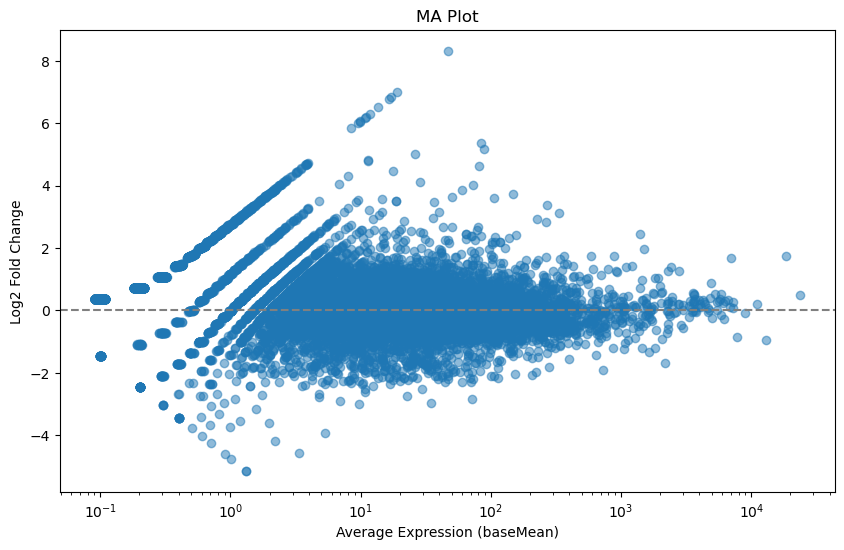

In [211]:
#ma plot
plt.figure(figsize=(10, 6))
plt.scatter(x=results_df['baseMean'], y=results_df['log2FoldChange'], alpha=0.5)
plt.xlabel('Average Expression (baseMean)')
plt.ylabel('Log2 Fold Change')
plt.title('MA Plot')
plt.axhline(y=0, color='grey', linestyle='--')  # Line at y=0
plt.xscale('log')  # Log scale for x-axis
plt.show()

Volcano plot

In [104]:
# Calculate -log10 P-values
results_df['minus_log10_pvalue'] = -np.log10(results_df['pvalue'])

In [105]:
# Set thresholds for significance
pvalue_threshold = 0.05
fold_change_threshold = 1  # log2 fold change

In [106]:
# Create a new column to mark the significant points
results_df['significant'] = (results_df['pvalue'] < pvalue_threshold) & (abs(results_df['log2FoldChange']) > fold_change_threshold)

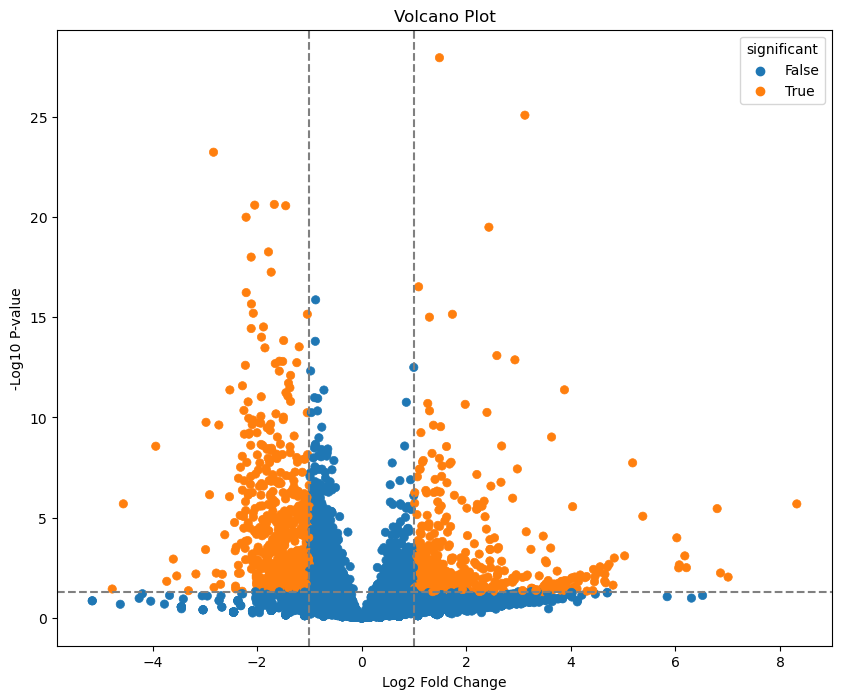

In [107]:
# Plotting
plt.figure(figsize=(10, 8))
sns.scatterplot(x='log2FoldChange', y='minus_log10_pvalue', data=results_df, hue='significant', edgecolor=None)

plt.title('Volcano Plot')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 P-value')
plt.axhline(-np.log10(pvalue_threshold), color='grey', ls='--')
plt.axvline(fold_change_threshold, color='grey', ls='--')
plt.axvline(-fold_change_threshold, color='grey', ls='--')

plt.show()

In [114]:
results_df.columns

Index(['baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue', 'padj',
       'minus_log10_pvalue', 'significant'],
      dtype='object')

In [111]:
results_df_2 = results_df.copy()

In [112]:
results_df_2['gene'] = Counts.index
results_df_2.head()

baseMean  log2FoldChange     lfcSE      stat    pvalue  padj  \
1  0.000000             NaN       NaN       NaN       NaN   NaN   
2  0.000000             NaN       NaN       NaN       NaN   NaN   
3  0.000000             NaN       NaN       NaN       NaN   NaN   
4  0.000000             NaN       NaN       NaN       NaN   NaN   
5  0.091066        0.353334  3.950882  0.089432  0.928739   NaN   

   minus_log10_pvalue  significant      gene  
1                 NaN        False      A1BG  
2                 NaN        False  A1BG.AS1  
3                 NaN        False      A1CF  
4                 NaN        False       A2M  
5            0.032106        False   A2M.AS1

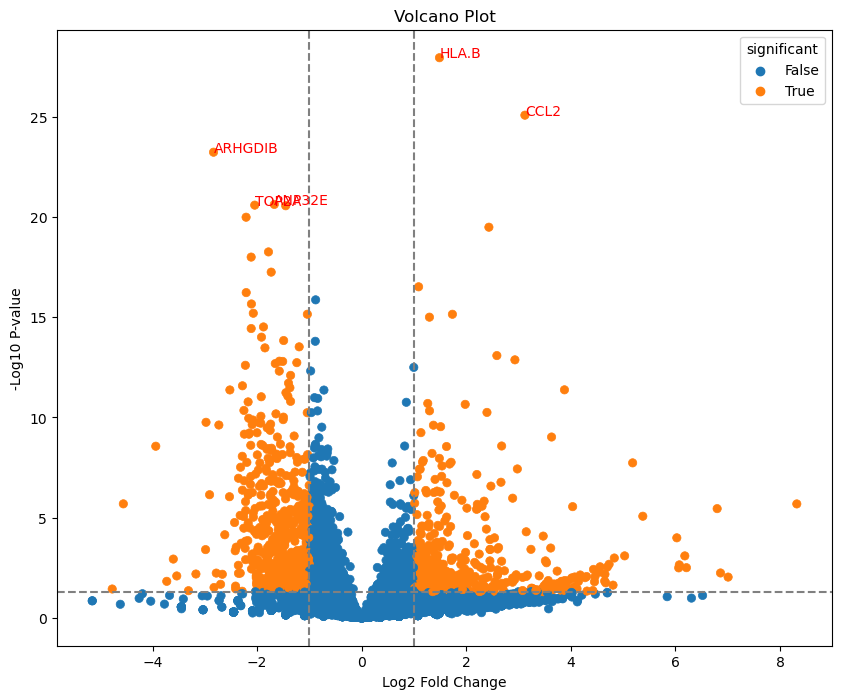

In [115]:
top_genes = results_df_2.nsmallest(5, 'pvalue')

# Plotting
plt.figure(figsize=(10, 8))
sns.scatterplot(x='log2FoldChange', y='minus_log10_pvalue', data=results_df_2, hue='significant', edgecolor=None)

# Annotate top genes
for _, row in top_genes.iterrows():
    plt.text(row['log2FoldChange'], row['minus_log10_pvalue'], row['gene'], color='red')

plt.title('Volcano Plot')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 P-value')
plt.axhline(-np.log10(pvalue_threshold), color='grey', ls='--')
plt.axvline(fold_change_threshold, color='grey', ls='--')
plt.axvline(-fold_change_threshold, color='grey', ls='--')

plt.show()

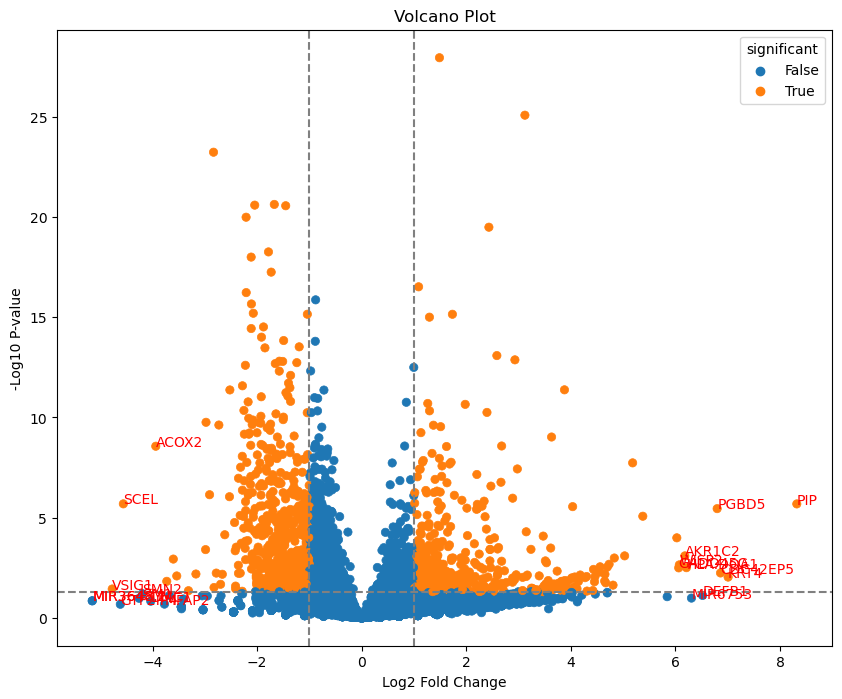

In [124]:
# Number of top genes to select from each category (upregulated and downregulated)
top_n = 10

# Select the top upregulated genes
top_upregulated = results_df_2.nlargest(top_n, 'log2FoldChange')

# Select the top downregulated genes
top_downregulated = results_df_2.nsmallest(top_n, 'log2FoldChange')

# Combine the two sets of genes
top_genes_2 = pd.concat([top_upregulated, top_downregulated])

# Plotting
plt.figure(figsize=(10, 8))
sns.scatterplot(x='log2FoldChange', y='minus_log10_pvalue', data=results_df_2, hue='significant', edgecolor=None)

# Annotate top genes
for _, row in top_genes_2.iterrows():
    plt.text(row['log2FoldChange'], row['minus_log10_pvalue'], row['gene'], color='red')  # Replace 'gene' with actual column name

plt.title('Volcano Plot')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 P-value')
plt.axhline(-np.log10(pvalue_threshold), color='grey', ls='--')
plt.axvline(fold_change_threshold, color='grey', ls='--')
plt.axvline(-fold_change_threshold, color='grey', ls='--')

plt.show()


Gese set enrichment

In [148]:
# Number of top genes to select from each category (upregulated and downregulated)
top_n_gsea = 100

# Select the top upregulated genes
top_upregulated_GSEA = results_df_2.nlargest(top_n_gsea, 'log2FoldChange')

# Select the top downregulated genes
top_downregulated_GSEA = results_df_2.nsmallest(top_n_gsea, 'log2FoldChange')

# Combine the two sets of genes
top_genes_GSEA = pd.concat([top_upregulated_GSEA, top_downregulated_GSEA])

c:\Users\aubhi\anaconda3\lib\site-packages\gseapy\enrichr.py:173: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
c:\Users\aubhi\anaconda3\lib\site-packages\gseapy\enrichr.py:173: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
c:\Users\aubhi\anaconda3\lib\site-packages\gseapy\enrichr.py:173: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
c:\Users\aubhi\anaconda3\lib\site-packages\gseapy\enrichr.py:173: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self

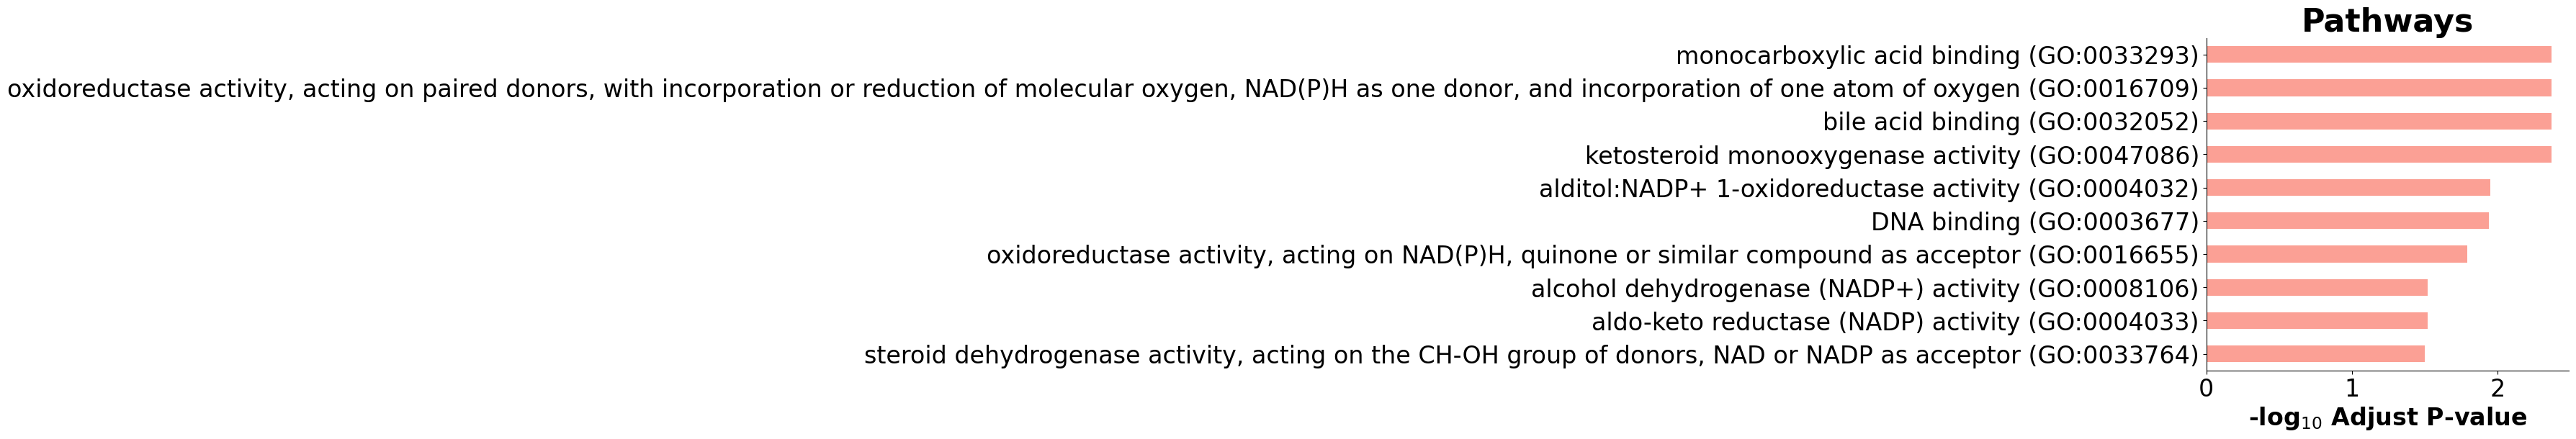

In [140]:
# GSEAPY on top_genes_GSEA
import gseapy as gp
from gseapy.plot import barplot, dotplot

# Create a list of gene names
gene_list = list(top_genes_GSEA['gene'])

# Run GSEA
enr = gp.enrichr(
    gene_list=gene_list,
    gene_sets=['KEGG_2019_Human', 'Reactome_2016', 'BioPlanet_2019', 'GO_Biological_Process_2018', 'GO_Cellular_Component_2018', 'GO_Molecular_Function_2018'], # 'ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X', 'ENCODE_Histone_Modifications_2015', 'ENCODE_TF_ChIP-seq_2015'
    description='test_name',
    outdir='test/enrichr_kegg',
    cutoff=0.5  # only get pathways with p-value < 0.05
)

# Plot the results
barplot(enr.res2d, title='Pathways')

Network analyses

In [150]:
# Netowrk plot of the top_gene_GSEA gene_list
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt

# Create a networkx graph object
G = nx.Graph()

for gene in gene_list:
    G.add_node(gene)

# Add edges
#G.add_edge('Gene1', 'Gene2')

# Visualize the network
#nx.draw(G, with_labels=True)
#plt.show()

In [151]:
import requests

In [152]:
# Construct the query for the STRING API
string_api_url = "https://string-db.org/api"
output_format = "json"
method = "/interaction_partners"
params = {
    "identifiers": "%0d".join(gene_list),  # Your list of genes
    "species": 9606,  # Human (Homo sapiens)
    "limit": 10,  # Limit the number of interactions (adjust as needed)
    "network_flavor": "confidence"  # Type of network
}

# Send the request to STRING
response = requests.post(f"{string_api_url}/{output_format}/{method}", data=params)

# Check if the request was successful
if response.status_code == 200:
    interactions = response.json()
    for interaction in interactions:
        # Extract interacting genes
        gene_a = interaction["preferredName_A"]
        gene_b = interaction["preferredName_B"]
        # Add edge if both genes are in your list
        if gene_a in gene_list and gene_b in gene_list:
            G.add_edge(gene_a, gene_b)
else:
    print("Failed to retrieve data")


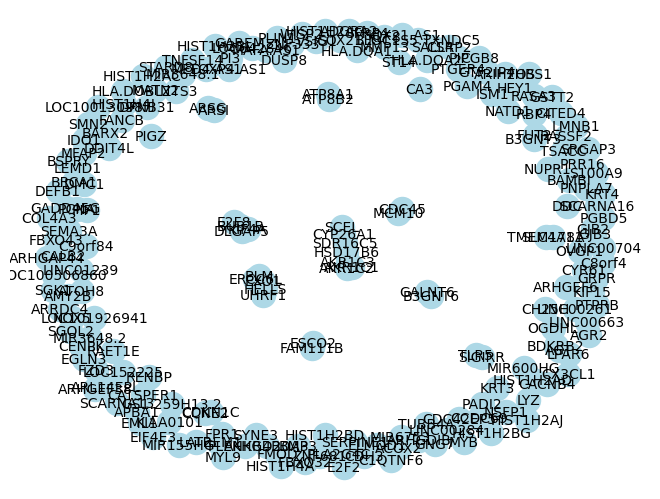

In [153]:
# Draw the network
nx.draw(G, with_labels=True, node_color='lightblue', font_size=10)
plt.show()

Network for just the top 10 genes

In [166]:
# Top 10 genes is gene_list
top10_gene_list = gene_list[0:10]
top10_gene_list

['PIP',
 'KRT4',
 'CDC42EP5',
 'PGBD5',
 'DEFB1',
 'MIR6753',
 'HLA.DQA1',
 'AKR1C2',
 'WISP2',
 'GADD45G']

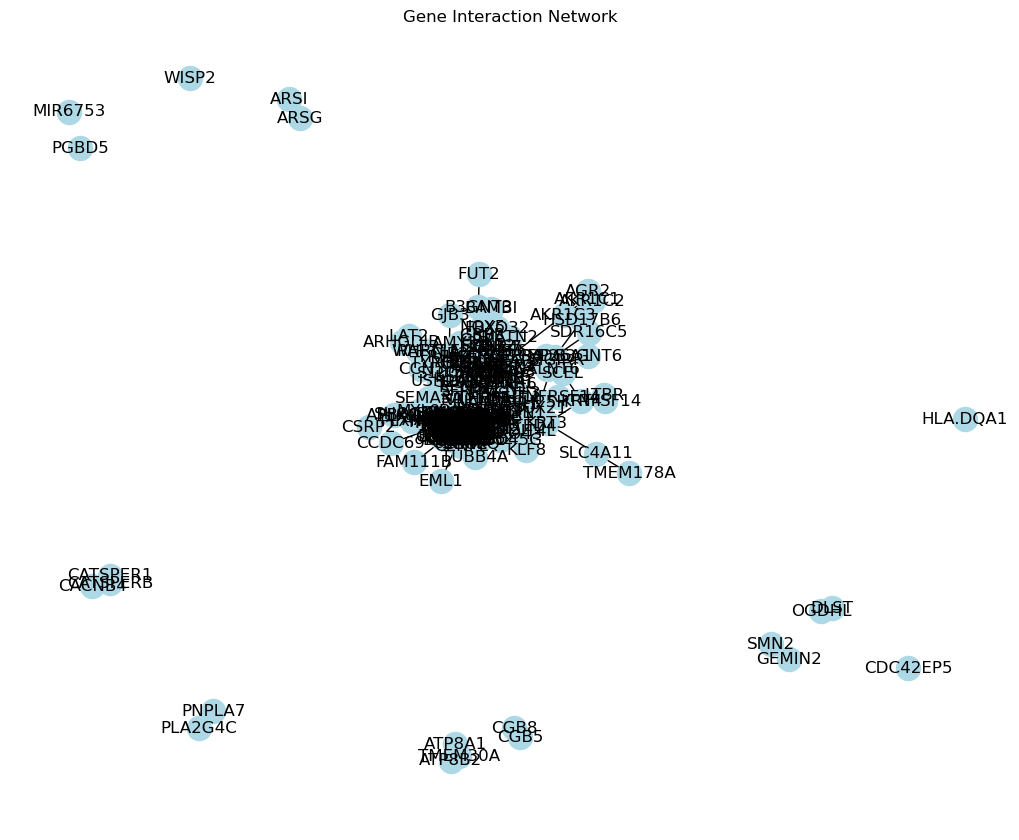

In [167]:
#gene_list = ['GENE1', 'GENE2', 'GENE3']  # Replace with your actual list of genes

# Create a network graph
G = nx.Graph()

# Add nodes for each gene
for gene in top10_gene_list:
    G.add_node(gene)

# Construct the query for the STRING API
string_api_url = "https://string-db.org/api"
output_format = "json"
method = "network"
params = {
    "identifiers": "%0d".join(gene_list),
    "species": 9606,  # Human (Homo sapiens)
    "limit": 100,  # Adjust as needed
    "network_flavor": "confidence"
}

# Send the request to STRING
response = requests.post(f"{string_api_url}/{output_format}/{method}", data=params)

# Check if the request was successful
if response.status_code == 200:
    interactions = response.json()
    for interaction in interactions:
        # Extract interacting genes
        gene_a = interaction.get("preferredName_A")
        gene_b = interaction.get("preferredName_B")
        # Add edge - consider removing the check to add more interactions
        if gene_a and gene_b:
            G.add_edge(gene_a, gene_b)
else:
    print("Failed to retrieve data")

# Draw the network
plt.figure(figsize=(10, 8))
nx.draw(G, with_labels=True, node_color='lightblue', font_size=12)
plt.title("Gene Interaction Network")
plt.show()


The interactions are there. Just not visible

In [170]:
def get_string_interactions(gene_list):
    base_url = "https://string-db.org/api"
    output_format = "json"
    method = "network"
    
    request_url = f"{base_url}/{output_format}/{method}"
    params = {
        "identifiers": "%0d".join(gene_list),
        "species": 9606,  # For Homo sapiens
        "limit": 100
    }
    
    response = requests.post(request_url, data=params)
    return response.json()

# Fetch interactions for the identified DEGs
top_interactions = get_string_interactions(gene_list)

In [173]:
def create_network(gene_list):
    # Retrieve interactions
    interactions = get_string_interactions(gene_list)

    # Create a network graph
    G = nx.Graph()
    for gene in gene_list:
        G.add_node(gene)
    
    # Process interactions to extract edge tuples
    edge_tuples = [(interaction['preferredName_A'], interaction['preferredName_B']) for interaction in interactions]

    # Add edges to the graph
    G.add_edges_from(edge_tuples)

    return G

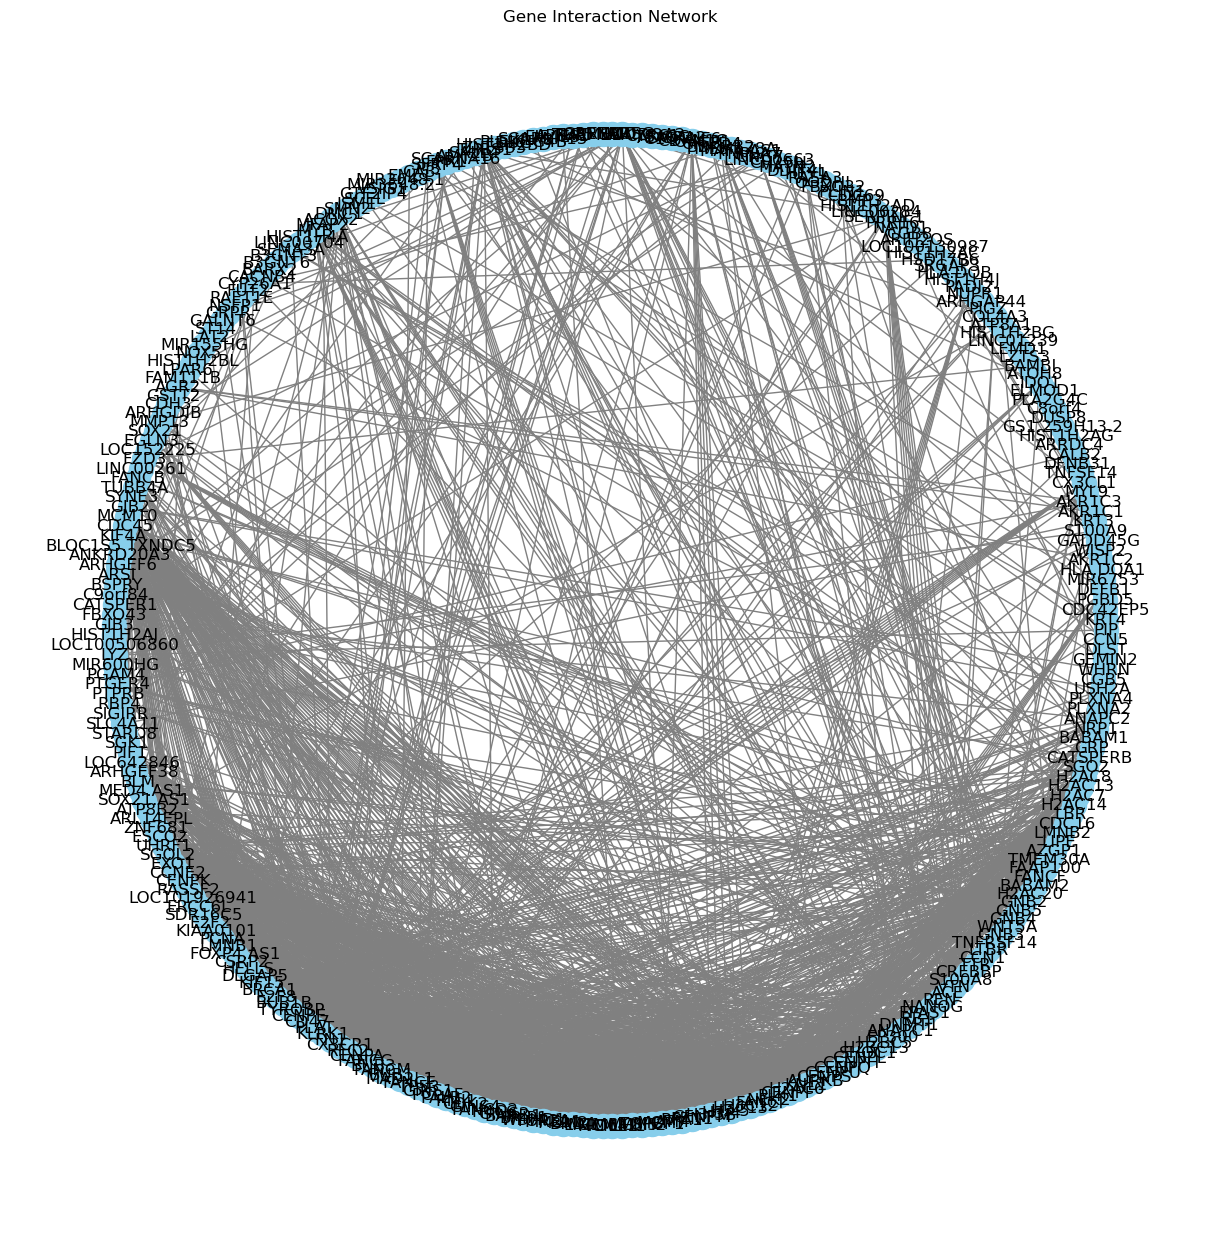

In [174]:
def plot_network(G):
    # Plot the network
    plt.figure(figsize=(12, 12))
    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray')
    plt.title("Gene Interaction Network")
    plt.show()


# Create and plot network for upregulated genes
G_top = create_network(gene_list)
plot_network(G_top)

Without label figures

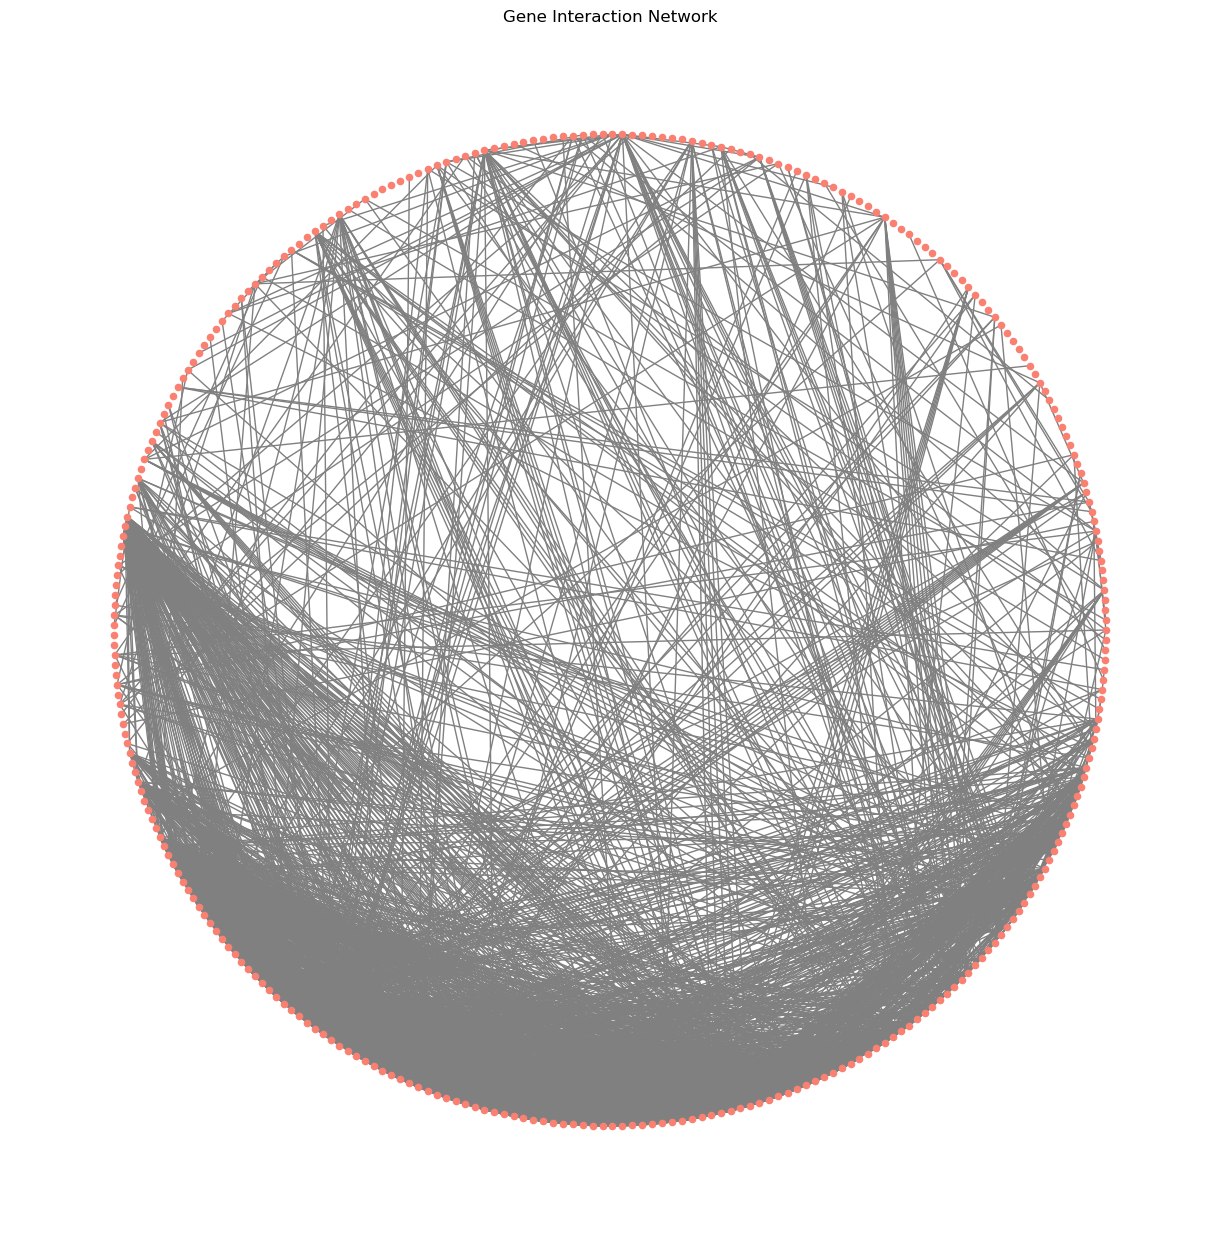

In [192]:
def plot_network_without_label(G):
    # Plot the network
    plt.figure(figsize=(12, 12))
    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=False, node_color='salmon', node_size= 20, edge_color='gray')
    plt.title("Gene Interaction Network")
    plt.show()


# Create and plot network for upregulated genes
G_top = create_network(gene_list)
plot_network_without_label(G_top)

In [181]:
# Create a list of gene names
gene_list_up = list(top_upregulated_GSEA['gene'])
gene_list_down = list(top_downregulated_GSEA['gene'])
print (gene_list_up)
print (gene_list_down)


['PIP', 'KRT4', 'CDC42EP5', 'PGBD5', 'DEFB1', 'MIR6753', 'HLA.DQA1', 'AKR1C2', 'WISP2', 'GADD45G', 'S100A9', 'KRT3', 'AKR1C1', 'AKR1C3', 'MYL9', 'CX3CL1', 'TNFSF14', 'DFNB31', 'CALB2', 'ARRDC4', 'HIST1H2AG', 'GS1.259H13.2', 'DUSP8', 'C8orf4', 'PLA2G4C', 'ELMOD1', 'IDO1', 'ATOH8', 'BAMBI', 'LZTS3', 'LEMD1', 'LINC01239', 'HIST1H2BG', 'ATP8A1', 'COL4A3', 'PIGZ', 'ARHGAP44', 'NUPR1', 'PADI2', 'HIST1H4J', 'HLA.DOB', 'SRGAP3', 'HSD17B6', 'HIST1H2AC', 'LOC100130987', 'ARIH2OS', 'CGB8', 'NATD1', 'PRR16', 'SERPINE1', 'LINC00284', 'HIST1H2AD', 'BMP3', 'CCDC69', 'PLIN1', 'FBXO32', 'OGDHL', 'RASA3', 'HEY1', 'DDIT4L', 'MATN2', 'CH25H', 'LINC00663', 'GNG7', 'PNPLA7', 'MAFA.AS1', 'TMEM178A', 'BDKRB2', 'CITED4', 'OVGP1', 'CDKN1C', 'C1QTNF6', 'ADGRA2', 'TSACC', 'CYR61', 'HLA.DQA2', 'ARSG', 'AGT', 'FMOD', 'RENBP', 'GAREM', 'TREM1', 'TLR5', 'APBA1', 'EIF4E3', 'SCARNA13', 'KLF8', 'PLEKHG4B', 'DDC', 'HIST1H2BD', 'ZNF333', 'THBS1', 'SALL4', 'AMY2B', 'SCARNA16', 'FPR1', 'SFRP4', 'PI3', 'CA3', 'EML1']
['MIR36

In [183]:
# Fetch interactions for the identified DEGs
top_up_interactions = get_string_interactions(gene_list_up)
top_down_interactions = get_string_interactions(gene_list_down)

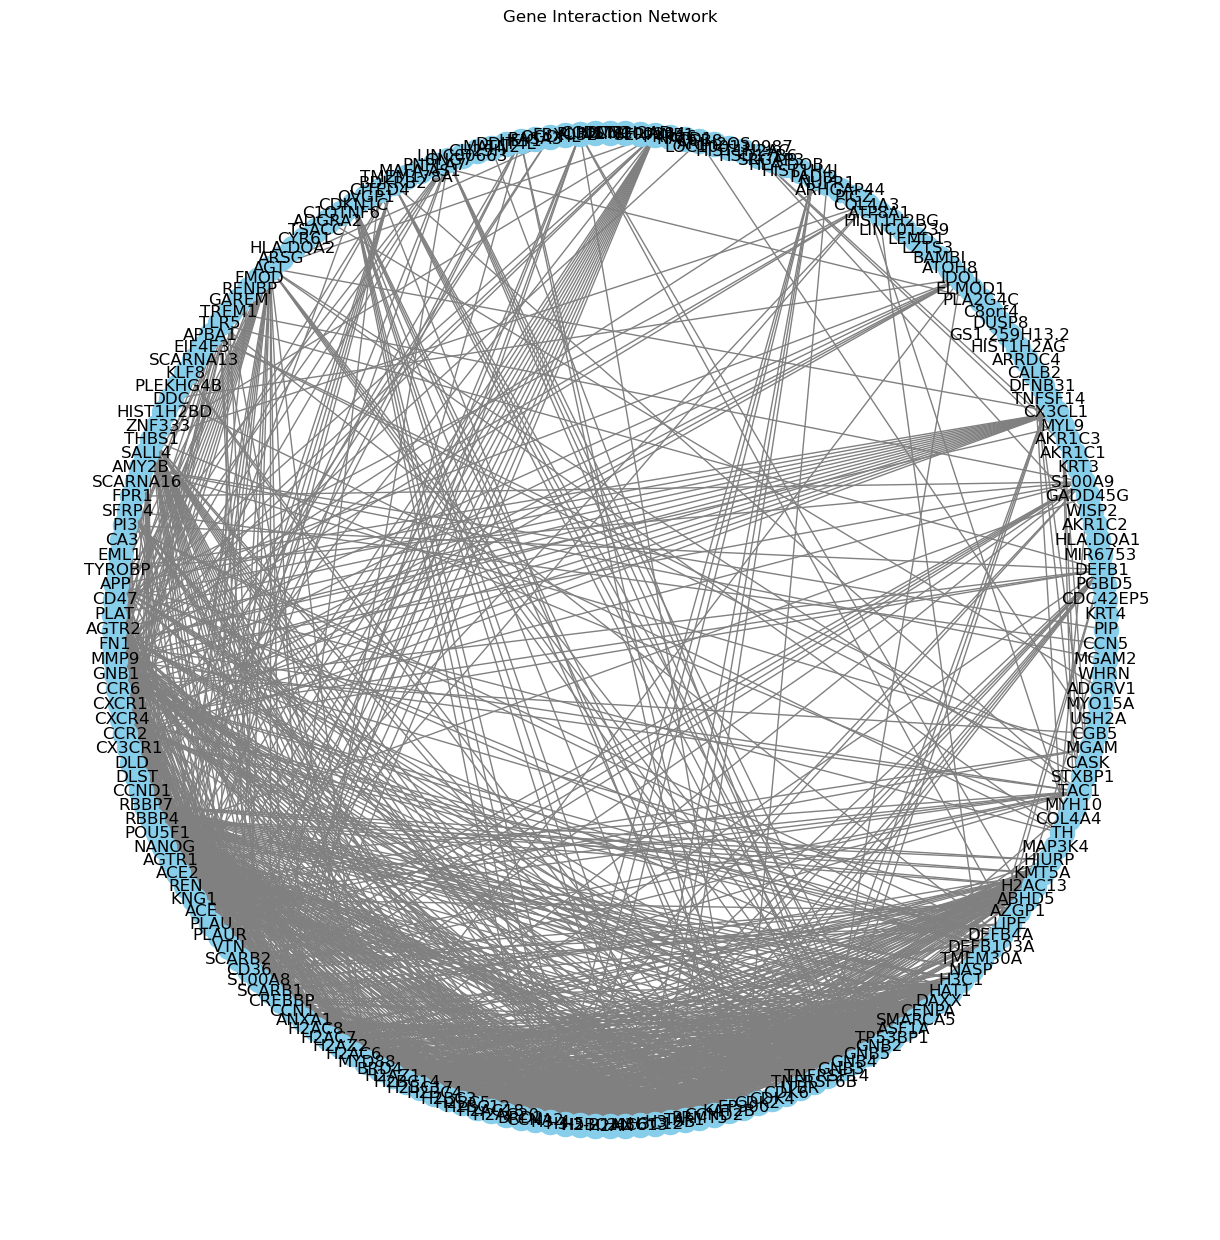

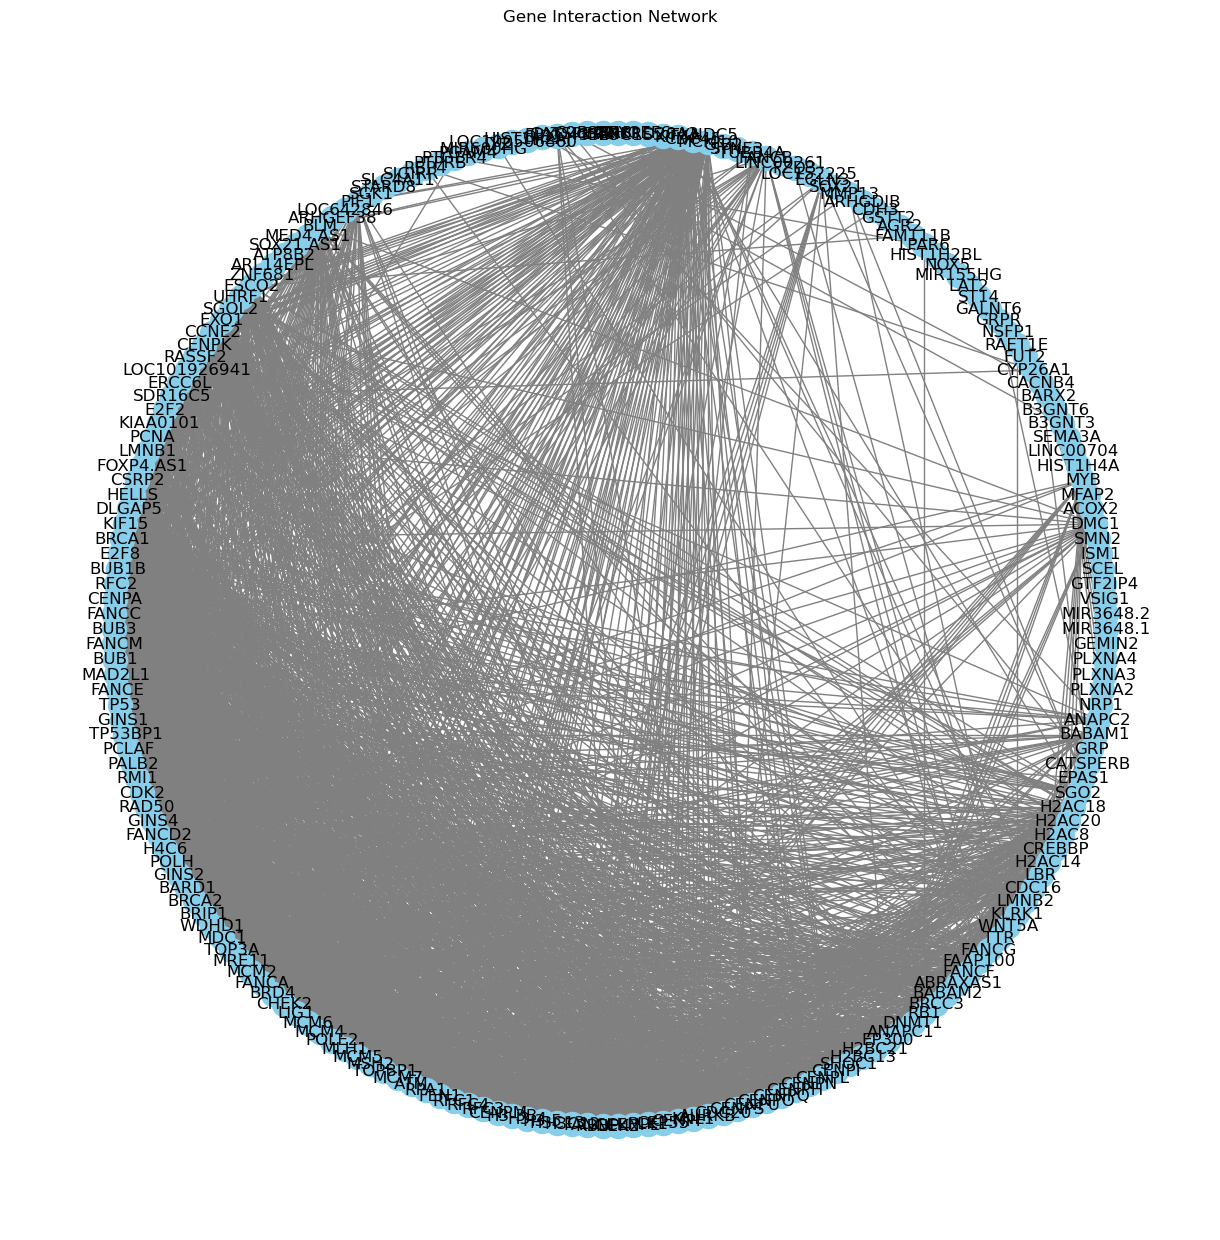

In [184]:
# Create and plot network for upregulated genes
G_top_up = create_network(gene_list_up)
plot_network(G_top_up)

# Create and plot network for downregulated genes
G_top_down = create_network(gene_list_down)
plot_network(G_top_down)

Misalignment with NetworkX Expectations!! Previous code attempted to add edges to the network graph without first converting the STRING API response into the correct edge tuple format. This resulted in errors because NetworkX couldn't interpret the data structure being provided.

Checking interaction with known data

Interactions found: 300
TP53 SFN
TP53 EP300
TP53 HIF1A
TP53 HDAC1
TP53 HSP90AA1
TP53 ATM
TP53 MDM4
TP53 CHEK2
TP53 BCL2
TP53 BCL2L1
TP53 PPP1R13L
TP53 DAXX
TP53 SIRT1
TP53 BRCA1
TP53 CDKN1A
TP53 TP53BP2
TP53 UBE3A
TP53 USP7
TP53 CREBBP
TP53 MDM2
TP53 RPA1
TP53 CDKN2A
TP53 TP53BP1
TP53 PTEN
TP53 HIPK2
TP53 RAD51
TP53 RCHY1
TP53 CREB1
TP53 HTT
TP53 NDN
TP53 AURKA
TP53 MAPK1
TP53 CCNG1
TP53 FOXO3
TP53 HSPA9
TP53 DNMT1
TP53 JUN
TP53 HSPA4
TP53 DDX5
TP53 CHEK1
TP53 PRKDC
TP53 MYC
TP53 NPM1
TP53 MAPK8
TP53 TBP
TP53 CCNA2
TP53 HMGB1
TP53 BAK1
TP53 KAT5
TP53 S100A4
TP53 SUMO1
TP53 ATR
TP53 DROSHA
TP53 HSP90AB1
TP53 BRCA2
TP53 FOXO4
TP53 S100B
TP53 STAT3
TP53 MAPK14
TP53 UBE2I
TP53 BAX
TP53 SP1
TP53 MAPK3
TP53 AKT1
TP53 SMAD2
TP53 PPIF
TP53 SMARCA4
TP53 GSK3B
TP53 ESR1
TP53 SNAI1
TP53 RRM2B
TP53 CASP8
TP53 YWHAZ
TP53 GADD45A
TP53 CDKN1B
TP53 BRD4
TP53 HDAC2
TP53 BRD7
TP53 NFKB1
TP53 SMYD2
TP53 IFI16
TP53 HSPA8
TP53 CDK2
TP53 G6PD
TP53 PPP1R13B
TP53 E2F1
TP53 TP73
TP53 KAT2B
TP53 RB1CC1
TP53 TAF

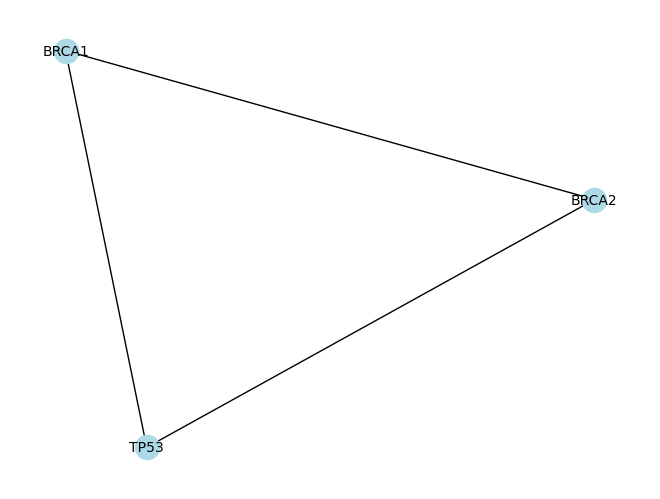

In [144]:
'''# Replace with your actual list of genes
gene_list_known = ['TP53', 'BRCA1', 'BRCA2']  # Example gene list

# Create a network graph
G = nx.Graph()

# Add nodes for each gene
for gene in gene_list_known:
    G.add_node(gene)

# Construct the query for the STRING API
string_api_url = "https://string-db.org/api"
output_format = "json"
method = "/interaction_partners"
params = {
    "identifiers": "%0d".join(gene_list_known),  # Your list of genes
    "species": 9606,  # Human (Homo sapiens)
    "limit": 100,  # Increased limit
    "network_flavor": "confidence"  # Type of network
}

# Send the request to STRING
response = requests.post(f"{string_api_url}/{output_format}/{method}", data=params)

# Check if the request was successful
if response.status_code == 200:
    interactions = response.json()
    print("Interactions found:", len(interactions))  # Debugging line
    for interaction in interactions:
        # Extract interacting genes
        gene_a = interaction["preferredName_A"]
        gene_b = interaction["preferredName_B"]
        print(gene_a, gene_b)  # Debugging line
        # Add edge if both genes are in your list
        if gene_a in gene_list_known and gene_b in gene_list_known:
            G.add_edge(gene_a, gene_b)
else:
    print("Failed to retrieve data")

# Draw the network
nx.draw(G, with_labels=True, node_color='lightblue', font_size=10)
plt.show()'''


Generating the network centrality

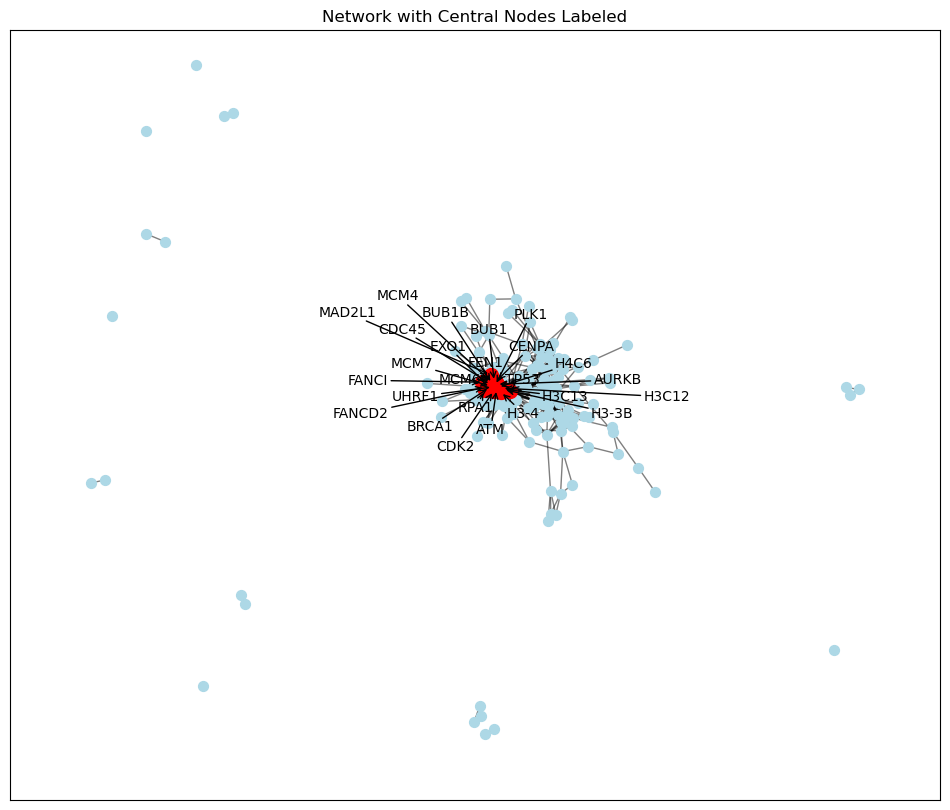

In [187]:
# Calculate degree centralities
degree_centralities = nx.degree_centrality(G)
# Threshold for selecting central nodes, e.g., top 10%
threshold = sorted(degree_centralities.values(), reverse=True)[int(len(degree_centralities) * 0.1)]

central_nodes = [node for node, centrality in degree_centralities.items() if centrality >= threshold]

# Visualization
pos = nx.spring_layout(G, seed=42)  # You can experiment with different layouts
plt.figure(figsize=(12, 10))

# Draw non-central nodes
nx.draw_networkx_nodes(G, pos, nodelist=set(G) - set(central_nodes), node_color='lightblue', node_size=50)

# Draw central nodes
nx.draw_networkx_nodes(G, pos, nodelist=central_nodes, node_color='red', node_size=100)

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.5)

# Draw labels for central nodes
texts = []
for node in central_nodes:
    texts.append(plt.text(pos[node][0], pos[node][1], node, ha='center', va='center'))

# Use adjustText to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black'))

plt.title(f"Network with Central Nodes Labeled")
plt.show()


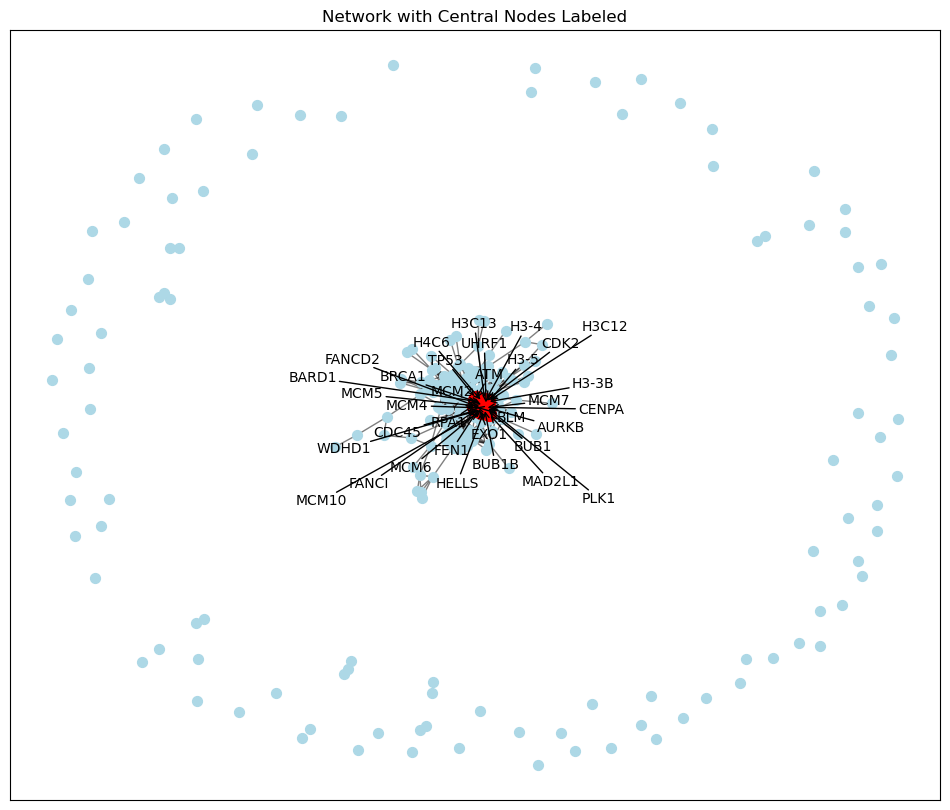

In [186]:
import networkx as nx
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Calculate degree centralities for G_top
degree_centralities = nx.degree_centrality(G_top)
# Threshold for selecting central nodes, e.g., top 10%
threshold = sorted(degree_centralities.values(), reverse=True)[int(len(degree_centralities) * 0.1)]

central_nodes = [node for node, centrality in degree_centralities.items() if centrality >= threshold]

# Visualization
pos = nx.spring_layout(G_top, seed=42)  # You can experiment with different layouts
plt.figure(figsize=(12, 10))

# Draw non-central nodes
nx.draw_networkx_nodes(G_top, pos, nodelist=set(G_top) - set(central_nodes), node_color='lightblue', node_size=50)

# Draw central nodes
nx.draw_networkx_nodes(G_top, pos, nodelist=central_nodes, node_color='red', node_size=100)

# Draw edges
nx.draw_networkx_edges(G_top, pos, alpha=0.5)

# Draw labels for central nodes
texts = []
for node in central_nodes:
    texts.append(plt.text(pos[node][0], pos[node][1], node, ha='center', va='center'))

# Use adjustText to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black'))

plt.title("Network with Central Nodes Labeled")
plt.show()


For Upregulated genes

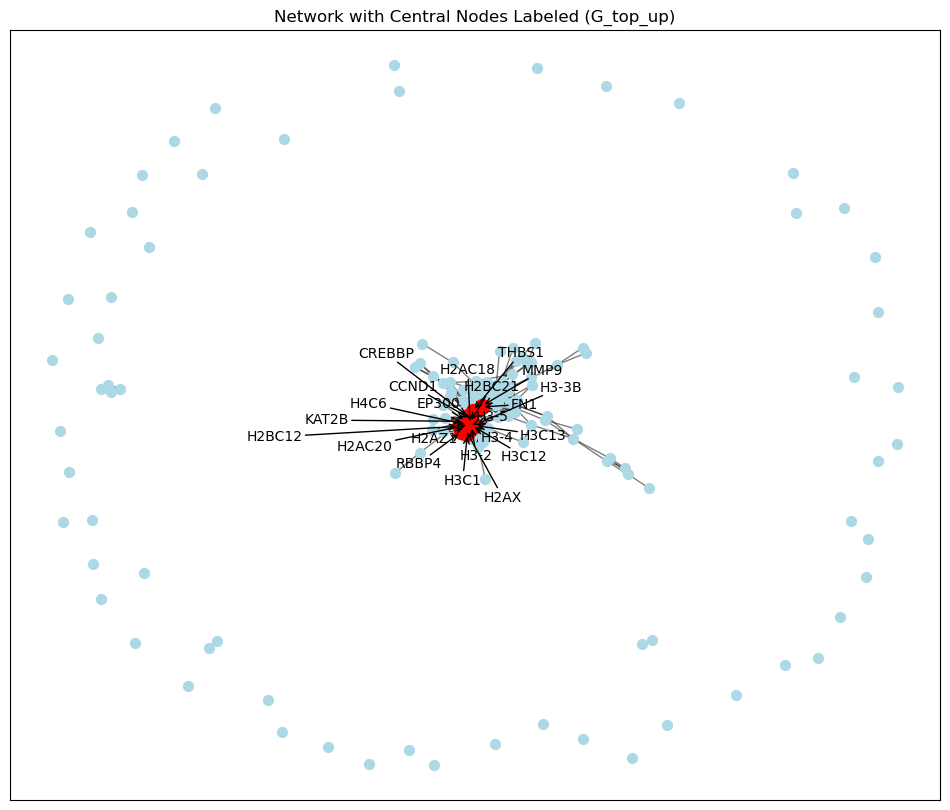

In [188]:
import networkx as nx
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Calculate degree centralities for G_top_up
degree_centralities = nx.degree_centrality(G_top_up)
# Threshold for selecting central nodes, e.g., top 10%
threshold = sorted(degree_centralities.values(), reverse=True)[int(len(degree_centralities) * 0.1)]

central_nodes = [node for node, centrality in degree_centralities.items() if centrality >= threshold]

# Visualization
pos = nx.spring_layout(G_top_up, seed=42)  # You can experiment with different layouts
plt.figure(figsize=(12, 10))

# Draw non-central nodes
nx.draw_networkx_nodes(G_top_up, pos, nodelist=set(G_top_up) - set(central_nodes), node_color='lightblue', node_size=50)

# Draw central nodes
nx.draw_networkx_nodes(G_top_up, pos, nodelist=central_nodes, node_color='red', node_size=100)

# Draw edges
nx.draw_networkx_edges(G_top_up, pos, alpha=0.5)

# Draw labels for central nodes
texts = []
for node in central_nodes:
    texts.append(plt.text(pos[node][0], pos[node][1], node, ha='center', va='center'))

# Use adjustText to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black'))

plt.title("Network with Central Nodes Labeled (G_top_up)")
plt.show()

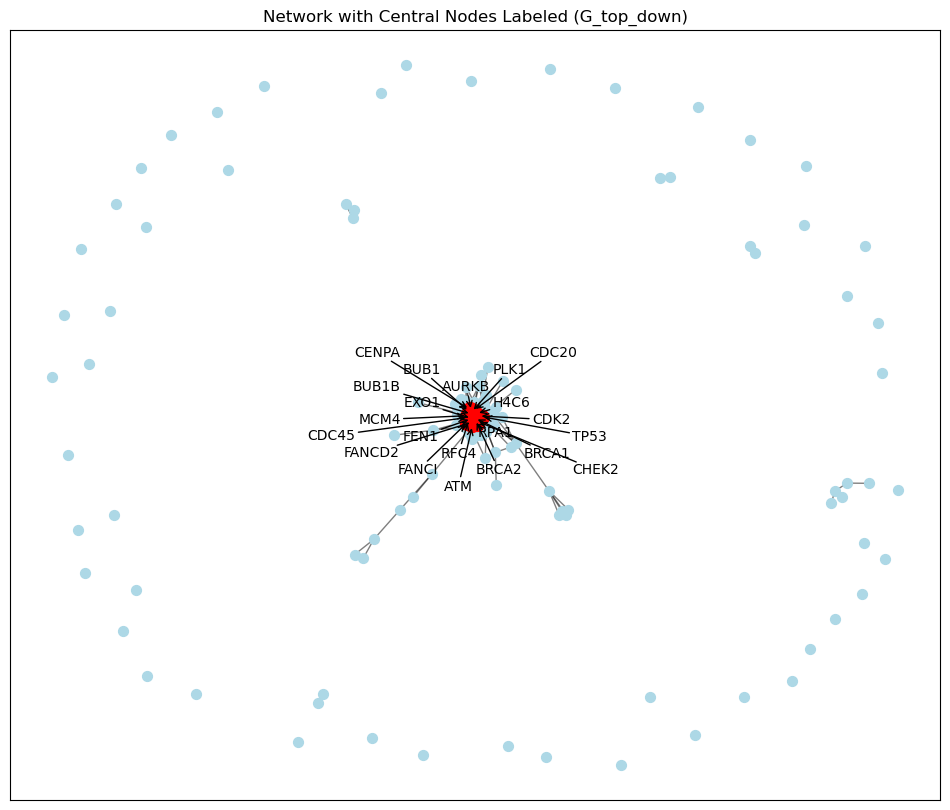

In [189]:
import networkx as nx
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Calculate degree centralities for G_top_down
degree_centralities = nx.degree_centrality(G_top_down)
# Threshold for selecting central nodes, e.g., top 10%
threshold = sorted(degree_centralities.values(), reverse=True)[int(len(degree_centralities) * 0.1)]

central_nodes = [node for node, centrality in degree_centralities.items() if centrality >= threshold]

# Visualization
pos = nx.spring_layout(G_top_down, seed=42)  # You can experiment with different layouts
plt.figure(figsize=(12, 10))

# Draw non-central nodes
nx.draw_networkx_nodes(G_top_down, pos, nodelist=set(G_top_down) - set(central_nodes), node_color='lightblue', node_size=50)

# Draw central nodes
nx.draw_networkx_nodes(G_top_down, pos, nodelist=central_nodes, node_color='red', node_size=100)

# Draw edges
nx.draw_networkx_edges(G_top_down, pos, alpha=0.5)

# Draw labels for central nodes
texts = []
for node in central_nodes:
    texts.append(plt.text(pos[node][0], pos[node][1], node, ha='center', va='center'))

# Use adjustText to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black'))

plt.title("Network with Central Nodes Labeled (G_top_down)")
plt.show()

Repeling th texts

In [122]:
from adjustText import adjust_text

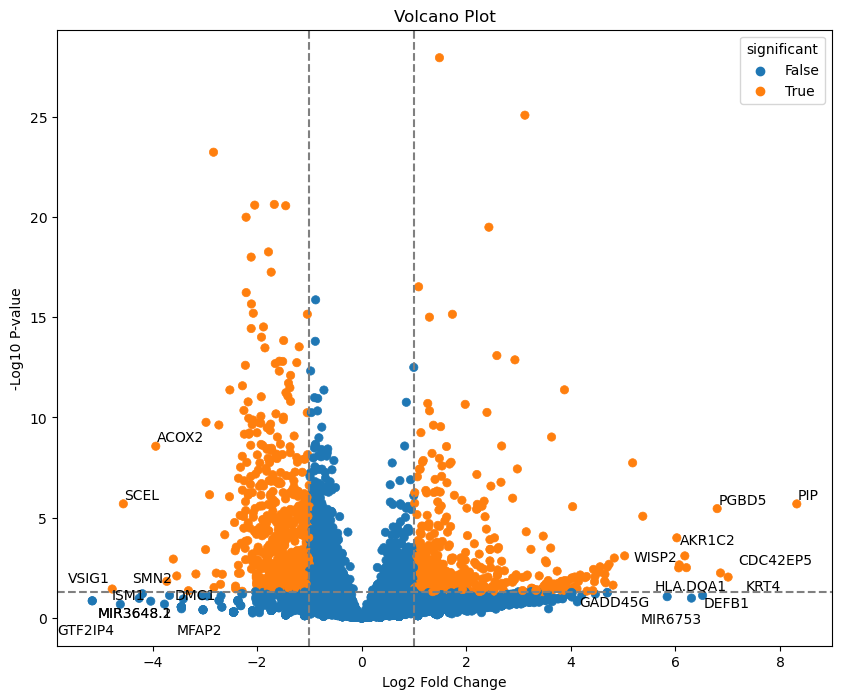

In [125]:
# Plotting
plt.figure(figsize=(10, 8))
sns.scatterplot(x='log2FoldChange', y='minus_log10_pvalue', data=results_df_2, hue='significant', edgecolor=None)

# Prepare a list to collect the text objects for adjustment
texts = []
for _, row in top_genes_2.iterrows():
    texts.append(plt.text(row['log2FoldChange'], row['minus_log10_pvalue'], row['gene']))  # Replace 'gene' with actual column name

plt.title('Volcano Plot')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 P-value')
plt.axhline(-np.log10(pvalue_threshold), color='grey', ls='--')
plt.axvline(fold_change_threshold, color='grey', ls='--')
plt.axvline(-fold_change_threshold, color='grey', ls='--')

# Adjust text positions
adjust_text(texts)

plt.show()

In [58]:
dds

<rpy2.robjects.methods.RS4 object at 0x000002615F529600> [RTYPES.S4SXP]
R classes: ('DESeqDataSet',)

PCA analysis

In [64]:
vst = DESeq2.vst(dds, blind=False)
vst_data = r('assay')(vst)

In [77]:
vst_data[0:5, 0:5]

array([[3.11294119, 3.11294119, 3.11294119, 3.11294119, 3.11294119],
       [3.11294119, 3.11294119, 3.11294119, 3.11294119, 3.11294119],
       [3.11294119, 3.11294119, 3.11294119, 3.11294119, 3.11294119],
       [3.11294119, 3.11294119, 3.11294119, 3.11294119, 3.11294119],
       [3.11294119, 3.11294119, 3.11294119, 3.11294119, 3.11294119]])

In [69]:
# Perform variance stabilizing transformation
vst = DESeq2.vst(dds, blind=False)

# Extract the transformed data
with localconverter(robjects.default_converter + pandas2ri.converter):
    vst_data = robjects.r['assay'](vst)


In [65]:
from sklearn.decomposition import PCA

In [78]:
colnames

<rpy2.robjects.vectors.StrVector object at 0x000002616D4450C0> [RTYPES.STRSXP]
R classes: ('character',)
['DMSO_1', 'DMSO_2', '250D_1', '250D_2', ..., '40D_1', '40D_2', '50D_1', '50D_2']

In [80]:
rownames

<rpy2.rinterface_lib.sexp.NULLType object at 0x0000026130ED6100> [RTYPES.NILSXP]

In [82]:
vst_df_2 = pd.DataFrame(vst_data)
vst_df_2.head()

0         1         2         3         4         5         6  \
0  3.112941  3.112941  3.112941  3.112941  3.112941  3.112941  3.112941   
1  3.112941  3.112941  3.112941  3.112941  3.112941  3.112941  3.112941   
2  3.112941  3.112941  3.112941  3.112941  3.112941  3.112941  3.112941   
3  3.112941  3.112941  3.112941  3.112941  3.112941  3.112941  3.112941   
4  3.112941  3.112941  3.112941  3.112941  3.112941  3.578979  3.112941   

          7         8         9  
0  3.112941  3.112941  3.112941  
1  3.112941  3.112941  3.112941  
2  3.112941  3.112941  3.112941  
3  3.112941  3.112941  3.112941  
4  3.112941  3.112941  3.112941

In [83]:
vst_df_2.shape

(26334, 10)

In [86]:
vst_df_2.columns = colnames
vst_df_2.head()

DMSO_1    DMSO_2    250D_1    250D_2     30D_1     30D_2     40D_1  \
0  3.112941  3.112941  3.112941  3.112941  3.112941  3.112941  3.112941   
1  3.112941  3.112941  3.112941  3.112941  3.112941  3.112941  3.112941   
2  3.112941  3.112941  3.112941  3.112941  3.112941  3.112941  3.112941   
3  3.112941  3.112941  3.112941  3.112941  3.112941  3.112941  3.112941   
4  3.112941  3.112941  3.112941  3.112941  3.112941  3.578979  3.112941   

      40D_2     50D_1     50D_2  
0  3.112941  3.112941  3.112941  
1  3.112941  3.112941  3.112941  
2  3.112941  3.112941  3.112941  
3  3.112941  3.112941  3.112941  
4  3.112941  3.112941  3.112941

In [91]:
# Set the index of vst_df_2 to be the same as the original count data
vst_df_2.index = Counts.index

In [92]:
vst_df_2.head()


DMSO_1    DMSO_2    250D_1    250D_2     30D_1     30D_2  \
Gene                                                                   
A1BG      3.112941  3.112941  3.112941  3.112941  3.112941  3.112941   
A1BG.AS1  3.112941  3.112941  3.112941  3.112941  3.112941  3.112941   
A1CF      3.112941  3.112941  3.112941  3.112941  3.112941  3.112941   
A2M       3.112941  3.112941  3.112941  3.112941  3.112941  3.112941   
A2M.AS1   3.112941  3.112941  3.112941  3.112941  3.112941  3.578979   

             40D_1     40D_2     50D_1     50D_2  
Gene                                              
A1BG      3.112941  3.112941  3.112941  3.112941  
A1BG.AS1  3.112941  3.112941  3.112941  3.112941  
A1CF      3.112941  3.112941  3.112941  3.112941  
A2M       3.112941  3.112941  3.112941  3.112941  
A2M.AS1   3.112941  3.112941  3.112941  3.112941

In [93]:
# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(vst_df_2.T)  # Transpose to get samples as rows

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

In [94]:
import seaborn as sns

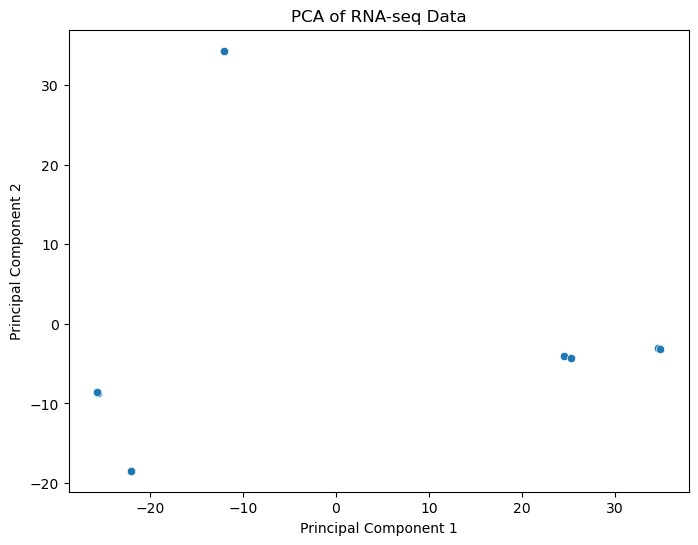

In [95]:
# Plotting
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=pca_df)
plt.title('PCA of RNA-seq Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()